In [5]:
!pip freeze > requirements.txt

In [1]:
# Loading system modules
import sys
import time
import os

# Loading common data related modules
import pandas as pd
import numpy as np
from math import sqrt

# Loading modelling algorithms
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.linear_model import  Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model

# Loading tools
from sklearn.model_selection import  train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
import missingno as msno

# Loading visualisation modules
from pandas_profiling import ProfileReport
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# Configure visualisations 
%matplotlib inline

# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [3]:
#Read data
path = "https://raw.githubusercontent.com/MarekLas/Medical_Charges_Regression/main/raw_data/insurance.csv"
_med_cost = pd.read_csv(path)
med_cost = _med_cost.copy()

In [4]:
# Review and clean the data 
med_cost.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [140]:
med_cost.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 286.5 KB


In [141]:
# Review the data and get intuition about it
med_cost.shape

(1338, 7)

In [142]:
# Find null values
med_cost.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

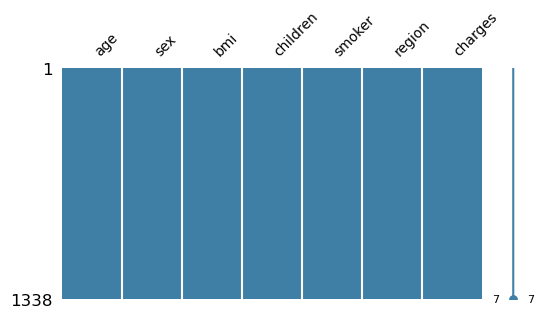

In [143]:
med_cost.isnull().sum()
msno.matrix(med_cost, figsize=(6,3), color=(0.25,0.5,0.65), fontsize=10);

In [144]:
# Search for illogical values
med_cost.describe()

age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

In [145]:
# Check categorical data and change them to numeric
med_cost['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

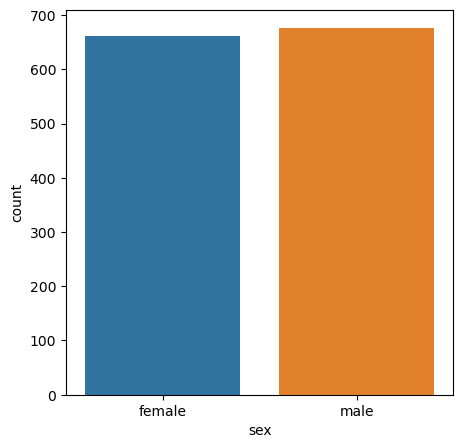

In [147]:
plt.figure(figsize=(5,5))
sns.countplot(x='sex', data=med_cost);

In [25]:
med_cost['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

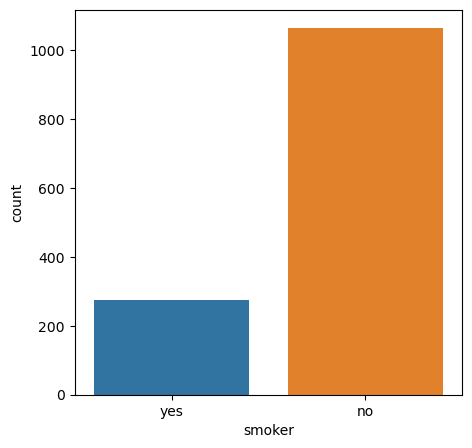

In [26]:
plt.figure(figsize=(5,5))
sns.countplot(x='smoker', data=med_cost);

In [27]:
med_cost['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

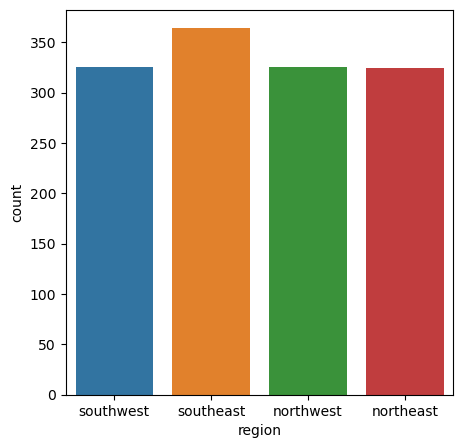

In [28]:
plt.figure(figsize=(5,5))
sns.countplot(x='region', data=med_cost);

In [29]:
med_cost['age_cat'] = np.nan
lst = [med_cost]

for col in lst:
    col.loc[(col['age'] >= 18) & (col['age'] <= 35), 'age_cat'] = 'Young Adult'
    col.loc[(col['age'] > 35) & (col['age'] <= 55), 'age_cat'] = 'Senior Adult'
    col.loc[col['age'] > 55, 'age_cat'] = 'Elder'

In [30]:
med_cost

age     sex     bmi  children smoker     region      charges  \
0      19  female  27.900         0    yes  southwest  16884.92400   
1      18    male  33.770         1     no  southeast   1725.55230   
2      28    male  33.000         3     no  southeast   4449.46200   
3      33    male  22.705         0     no  northwest  21984.47061   
4      32    male  28.880         0     no  northwest   3866.85520   
...   ...     ...     ...       ...    ...        ...          ...   
1333   50    male  30.970         3     no  northwest  10600.54830   
1334   18  female  31.920         0     no  northeast   2205.98080   
1335   18  female  36.850         0     no  southeast   1629.83350   
1336   21  female  25.800         0     no  southwest   2007.94500   
1337   61  female  29.070         0    yes  northwest  29141.36030   

           age_cat  
0      Young Adult  
1      Young Adult  
2      Young Adult  
3      Young Adult  
4      Young Adult  
...            ...  
1333  Senior Adult  
1334   Young Adult  
1335   Young Adult  
1336   Young Adult  
1337         Elder  

[1338 rows x 8 columns]

In [31]:
med_cost['age_cat'].value_counts()

Young Adult     574
Senior Adult    548
Elder           216
Name: age_cat, dtype: int64

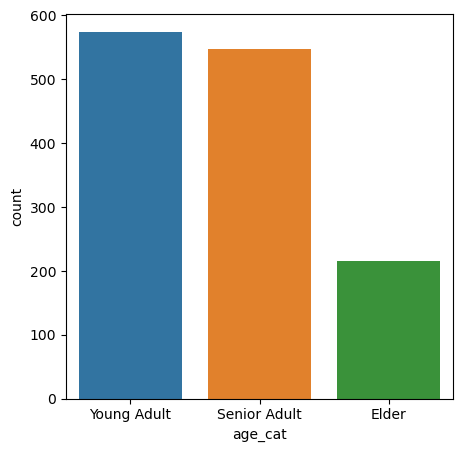

In [32]:
plt.figure(figsize=(5,5))
sns.countplot(x='age_cat', data=med_cost);

In [33]:
med_cost["weight_condition"] = np.nan
lst = [med_cost]

for col in lst:
    col.loc[col["bmi"] < 18.5, "weight_condition"] = "Underweight"
    col.loc[(col["bmi"] >= 18.5) & (col["bmi"] < 24.986), "weight_condition"] = "Normal Weight"
    col.loc[(col["bmi"] >= 25) & (col["bmi"] < 29.926), "weight_condition"] = "Overweight"
    col.loc[col["bmi"] >= 30, "weight_condition"] = "Obese"

In [34]:
med_cost['weight_condition'].value_counts()

Obese            707
Overweight       386
Normal Weight    225
Underweight       20
Name: weight_condition, dtype: int64

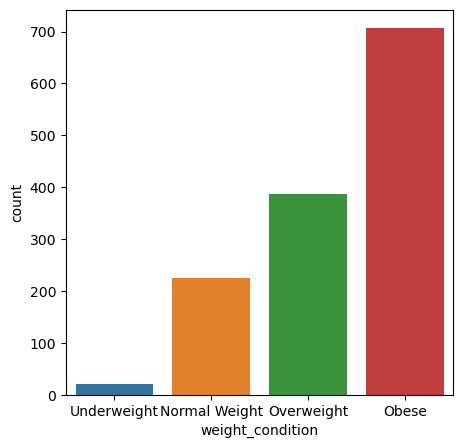

In [35]:
plt.figure(figsize=(5,5))
sns.countplot(x='weight_condition', data=med_cost,order=["Underweight", "Normal Weight","Overweight","Obese"]);

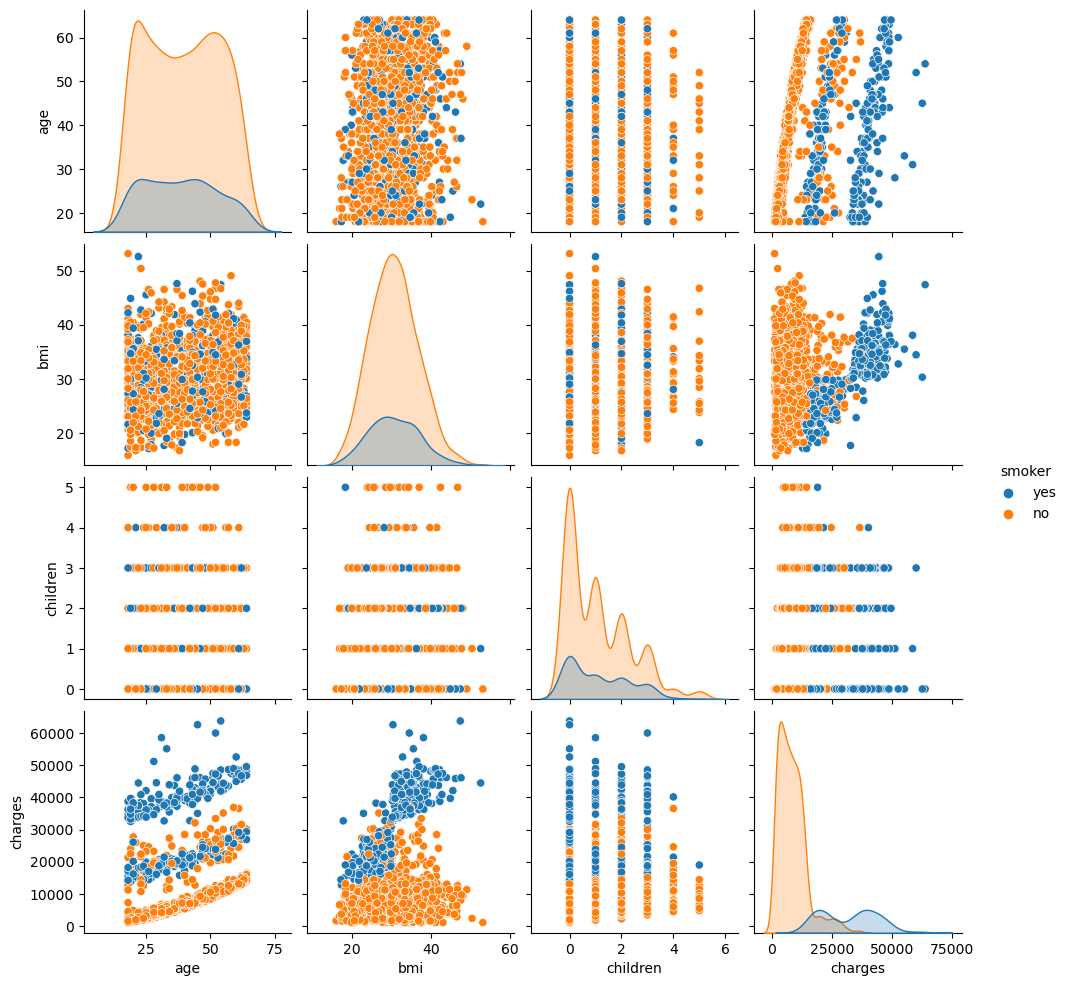

In [36]:
# Check for the dependencies in the data with smoker data
_=sns.pairplot(med_cost,hue='smoker')

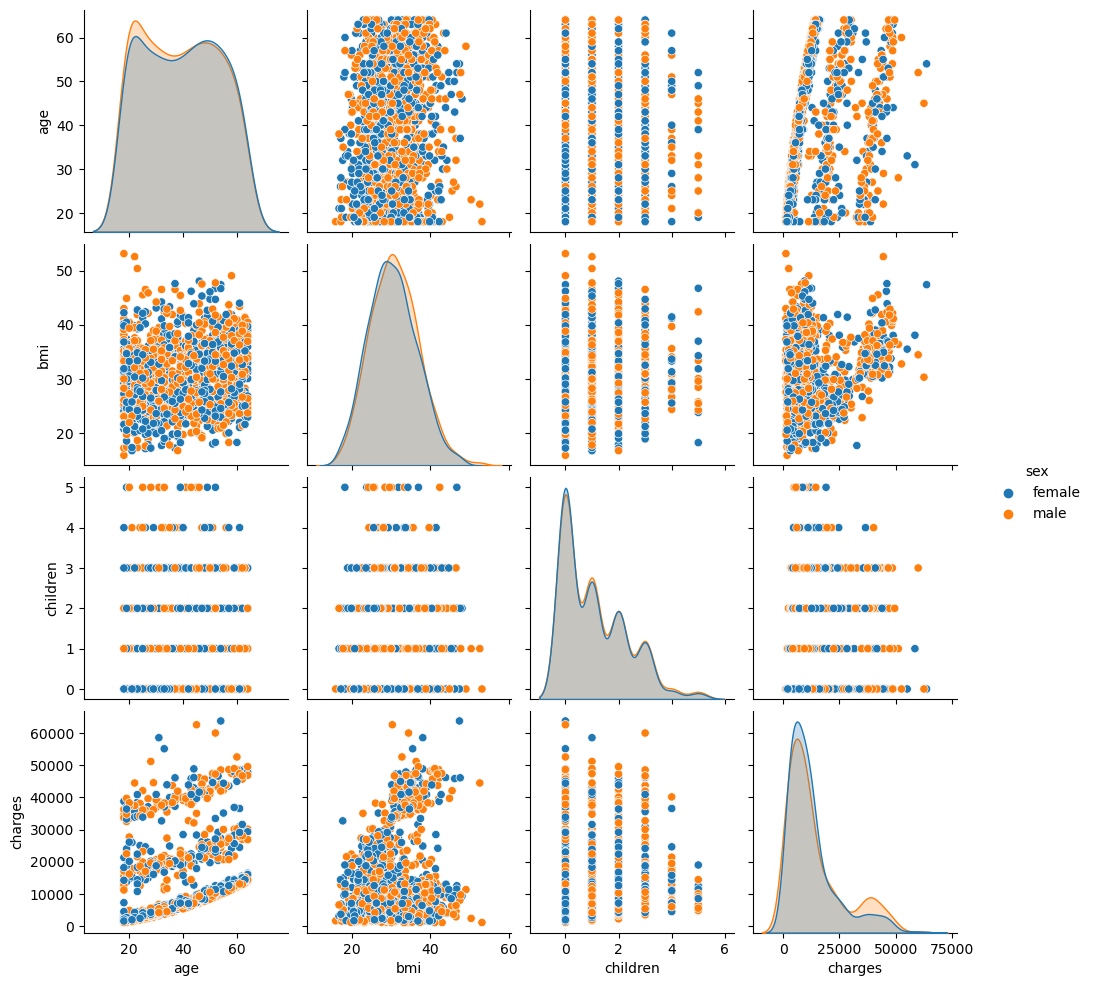

In [37]:
# Check for the dependencies in the data with sex data
_=sns.pairplot(med_cost,hue='sex')

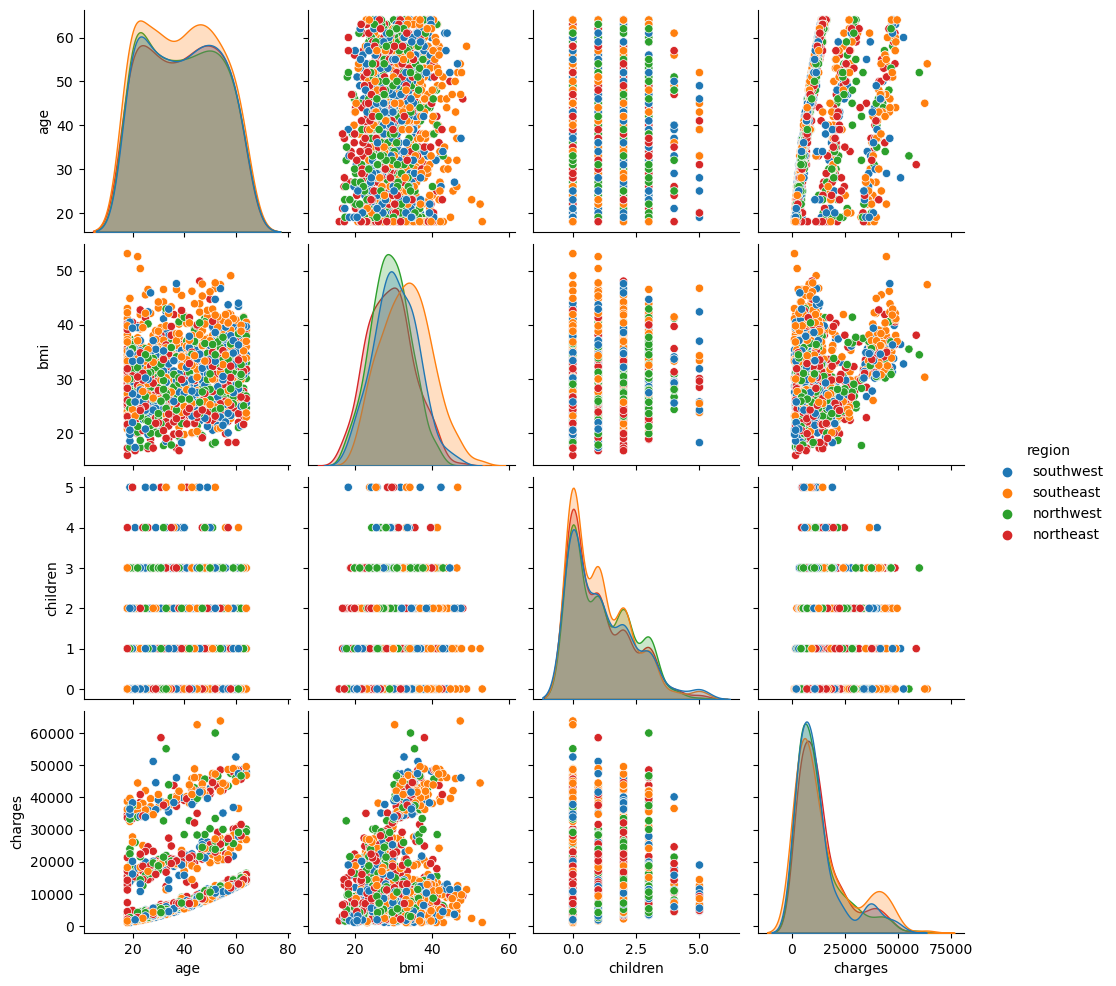

In [38]:
# Check for the dependencies in the data with region data
_=sns.pairplot(med_cost,hue='region')

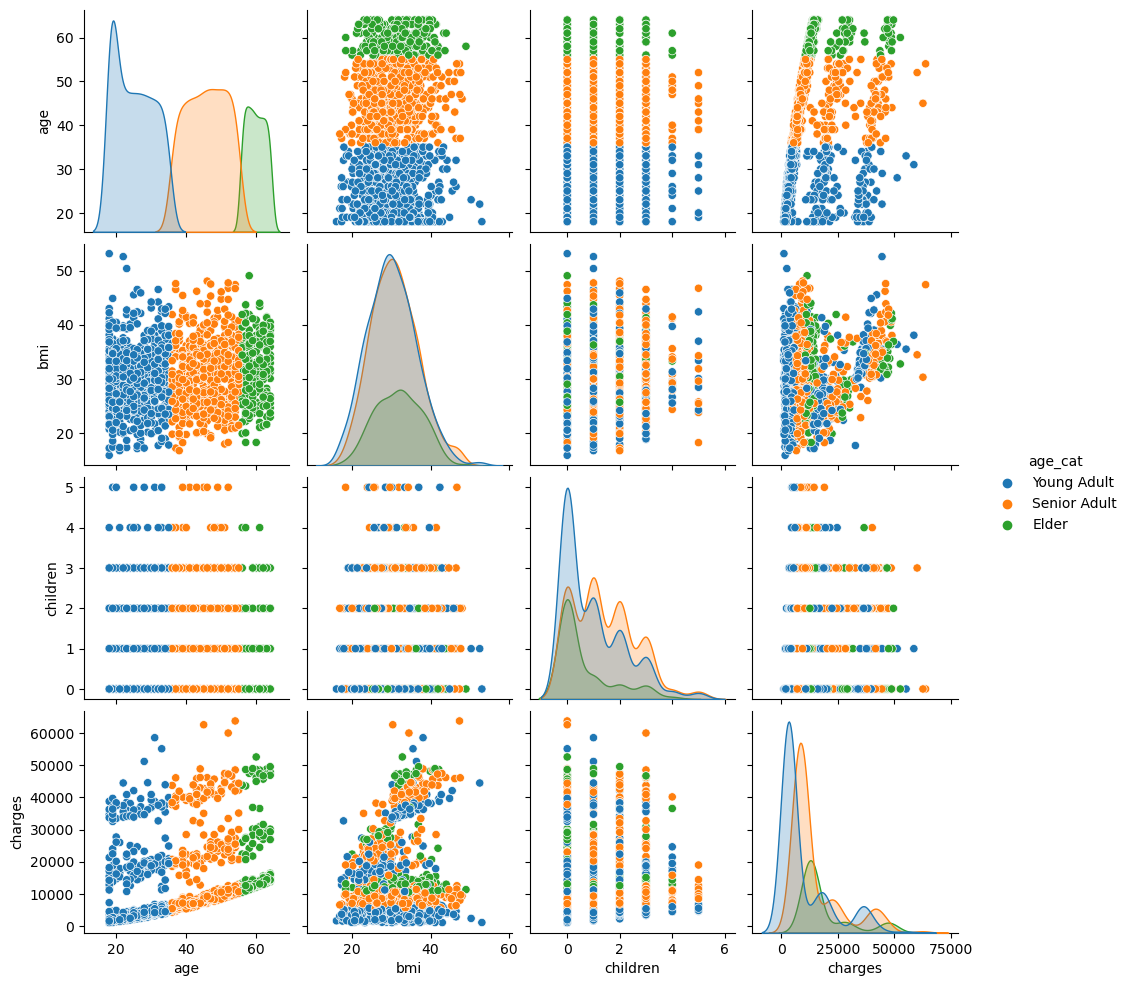

In [39]:
# Check for the dependencies in the data with age cathegory data
_=sns.pairplot(med_cost,hue='age_cat')

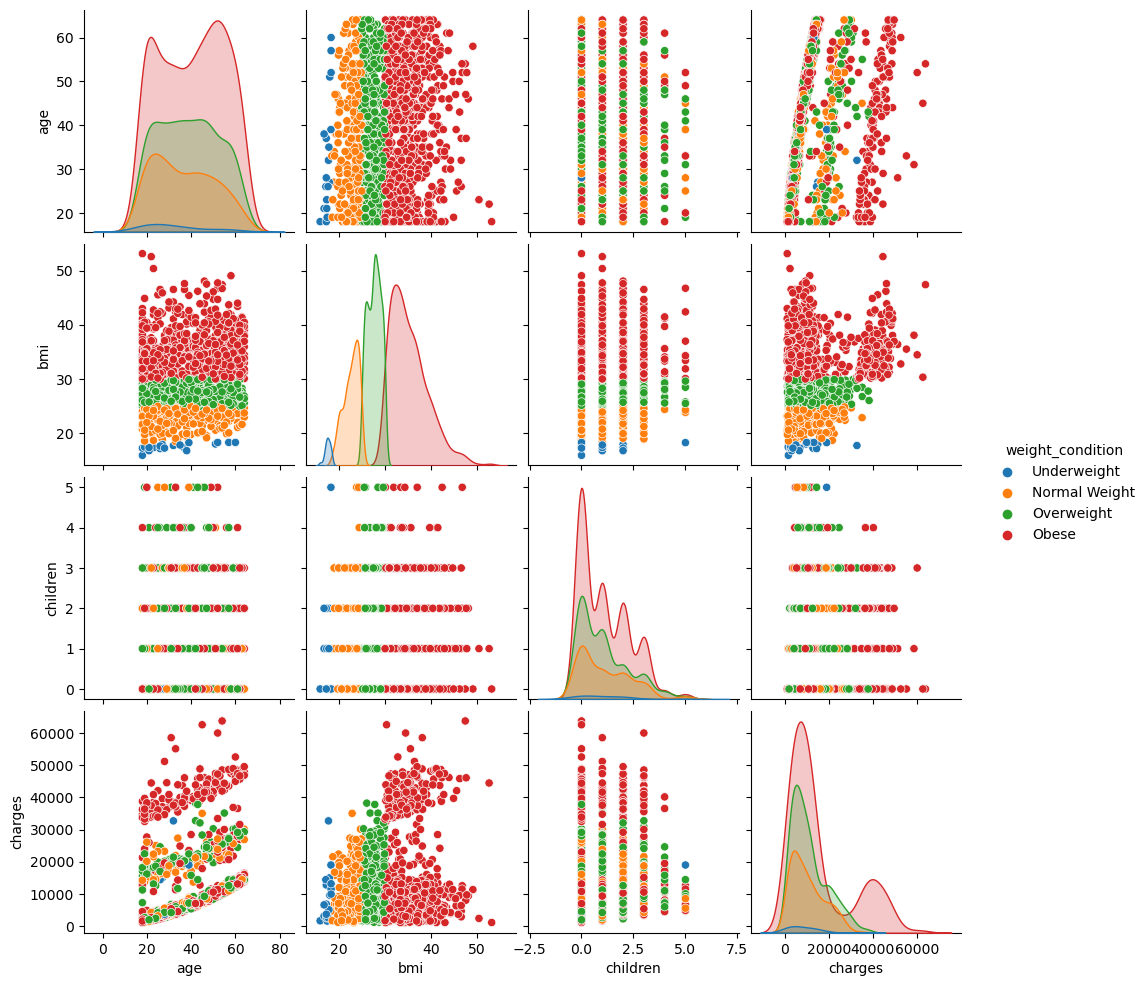

In [40]:
# Check for the dependencies in the data with weight condition data
_=sns.pairplot(med_cost,hue='weight_condition', hue_order=["Underweight", "Normal Weight","Overweight","Obese"])

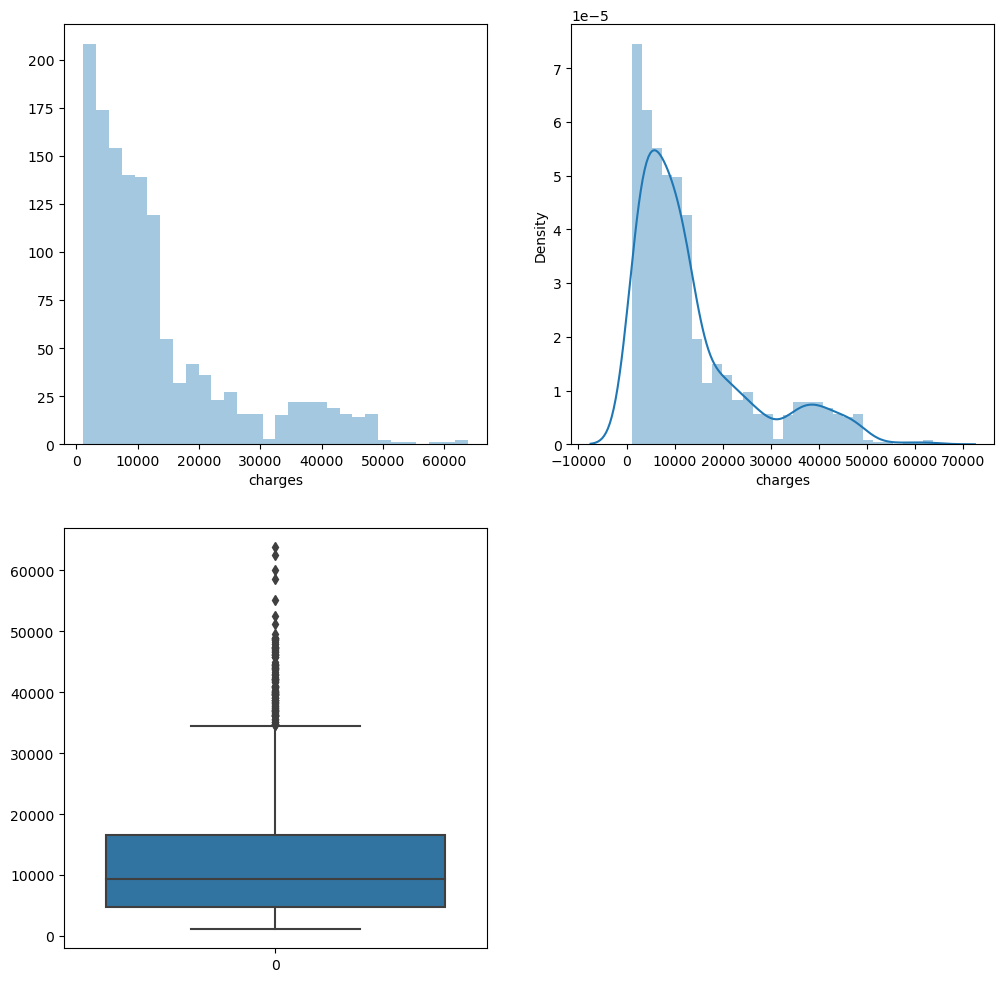

In [41]:
# Explore the charges column
rows = 2
cols = 2
i = 0

plt.figure(figsize=(cols * 6, rows * 6))

i += 1
plt.subplot(rows, cols, i)
plt.xticks(range(0, 80000, 10000))
_ = sns.distplot(med_cost['charges'], kde=False)

i += 1
plt.subplot(rows, cols, i)
_ = sns.distplot(med_cost['charges'])

i += 1
plt.subplot(rows, cols, i)
plt.xticks(range(0, 31, 4))
plt.xlim(0, 30)
_ = sns.boxplot(med_cost['charges'])

In [42]:
med_cost.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'age_cat', 'weight_condition'],
      dtype='object')

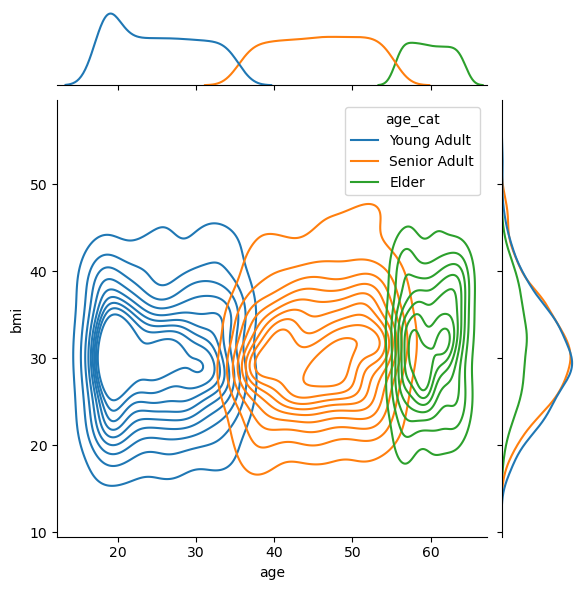

In [43]:
# check correlation graph
sns.jointplot(x='age' , y='bmi' , data=med_cost , size=5, hue='age_cat', kind='kde')

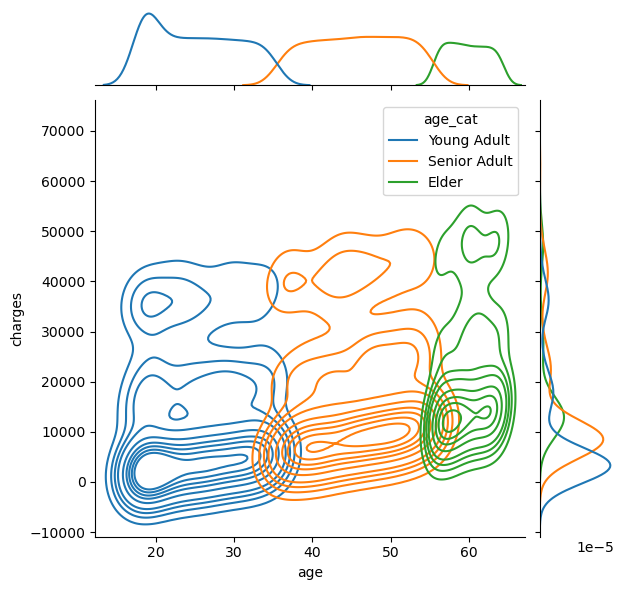

In [44]:
# check correlation graph
sns.jointplot(x='age' , y='charges' , data=med_cost, hue='age_cat', kind='kde', size=8);

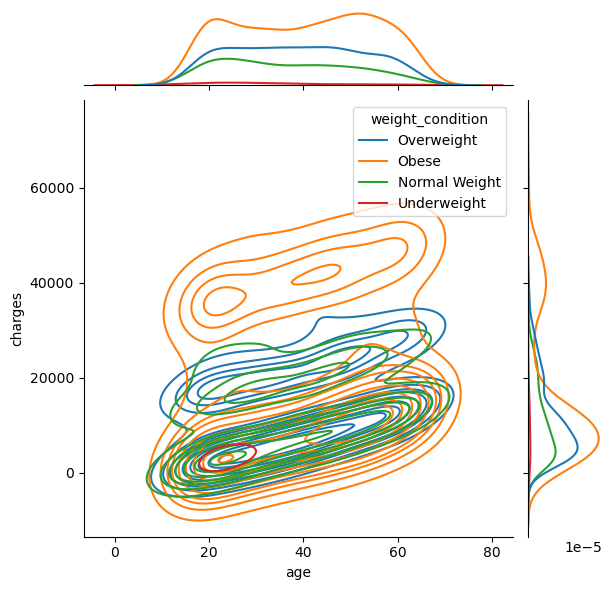

In [45]:
# check correlation graph
sns.jointplot(x='age' , y='charges' , data=med_cost , hue='weight_condition', kind='kde', size=10)

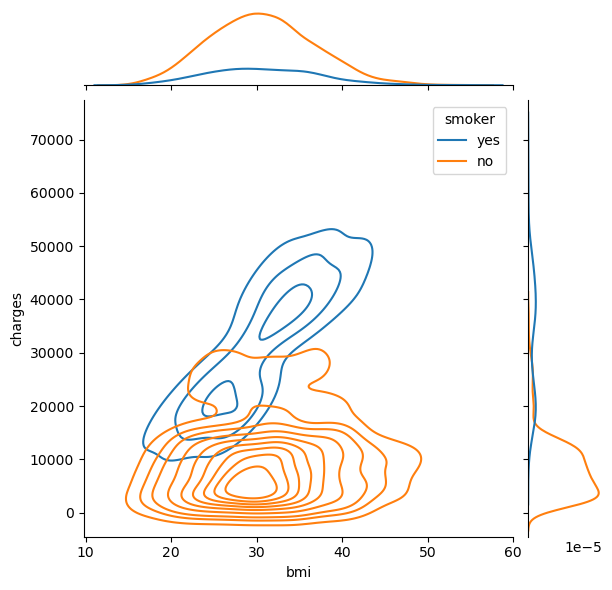

In [46]:
# check correlation graph
sns.jointplot(x='bmi' , y='charges' , data=med_cost , hue='smoker', kind='kde', size=10)

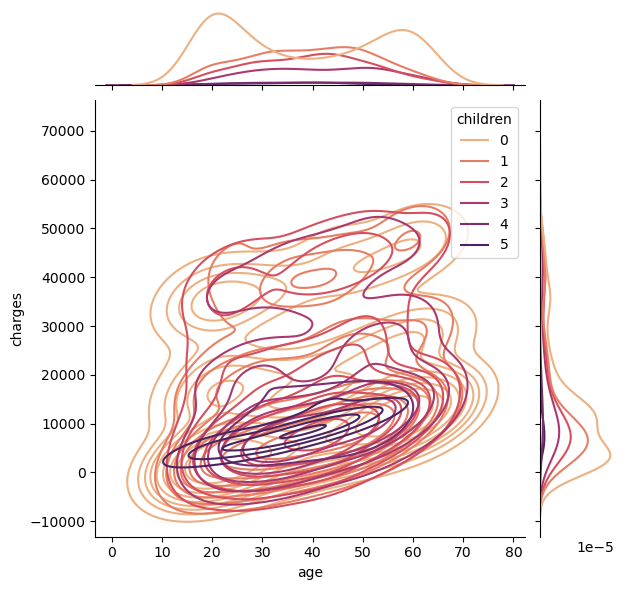

In [47]:
# check correlation graph
sns.jointplot(x='age' , y='charges' , data=med_cost , hue='children', kind='kde', size=10, palette='flare')

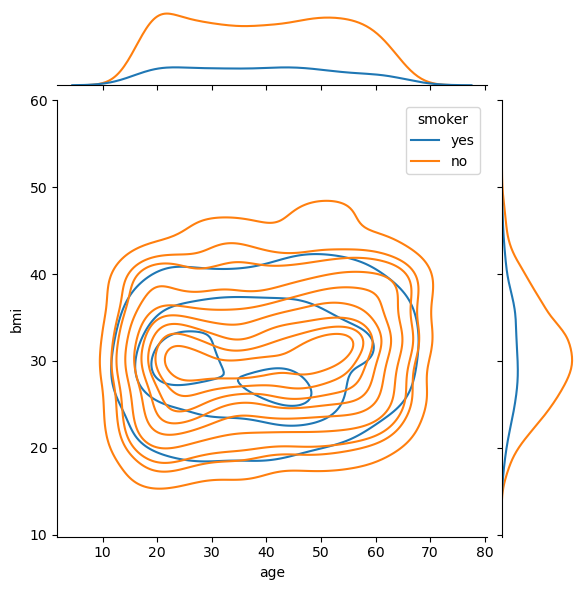

In [48]:
# check correlation graph
sns.jointplot(x='age' , y='bmi' , data=med_cost , hue='smoker', kind='kde', size=10);

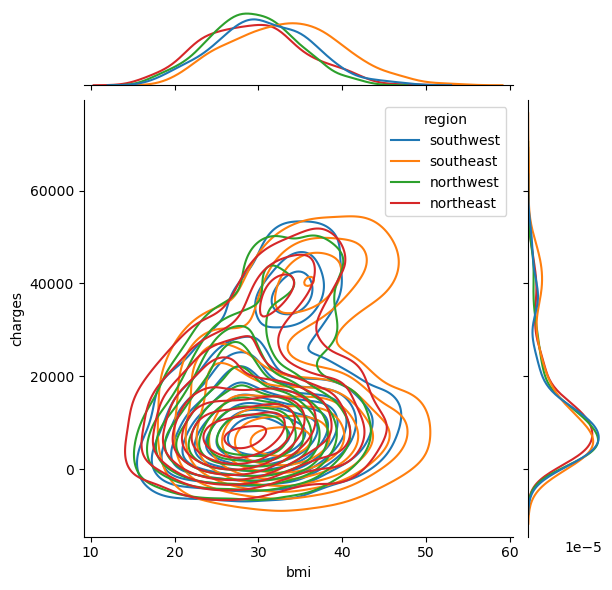

In [49]:
# check correlation graph
sns.jointplot(x='bmi' , y='charges' , data=med_cost , hue='region', kind='kde', size=10)

In [50]:
# med_cost.drop(['age'], axis=1,inplace=True)

In [52]:
#One hot encoding
med_cost = pd.get_dummies(med_cost)
med_cost.head()

age     bmi  children      charges  sex_female  sex_male  smoker_no  \
0   19  27.900         0  16884.92400           1         0          0   
1   18  33.770         1   1725.55230           0         1          1   
2   28  33.000         3   4449.46200           0         1          1   
3   33  22.705         0  21984.47061           0         1          1   
4   32  28.880         0   3866.85520           0         1          1   

   smoker_yes  region_northeast  region_northwest  region_southeast  \
0           1                 0                 0                 0   
1           0                 0                 0                 1   
2           0                 0                 0                 1   
3           0                 0                 1                 0   
4           0                 0                 1                 0   

   region_southwest  age_cat_Elder  age_cat_Senior Adult  age_cat_Young Adult  \
0                 1              0                     0                    1   
1                 0              0                     0                    1   
2                 0              0                     0                    1   
3                 0              0                     0                    1   
4                 0              0                     0                    1   

   weight_condition_Normal Weight  weight_condition_Obese  \
0                               0                       0   
1                               0                       1   
2                               0                       1   
3                               1                       0   
4                               0                       0   

   weight_condition_Overweight  weight_condition_Underweight  
0                            1                             0  
1                            0                             0  
2                            0                             0  
3                            0                             0  
4                            1                             0

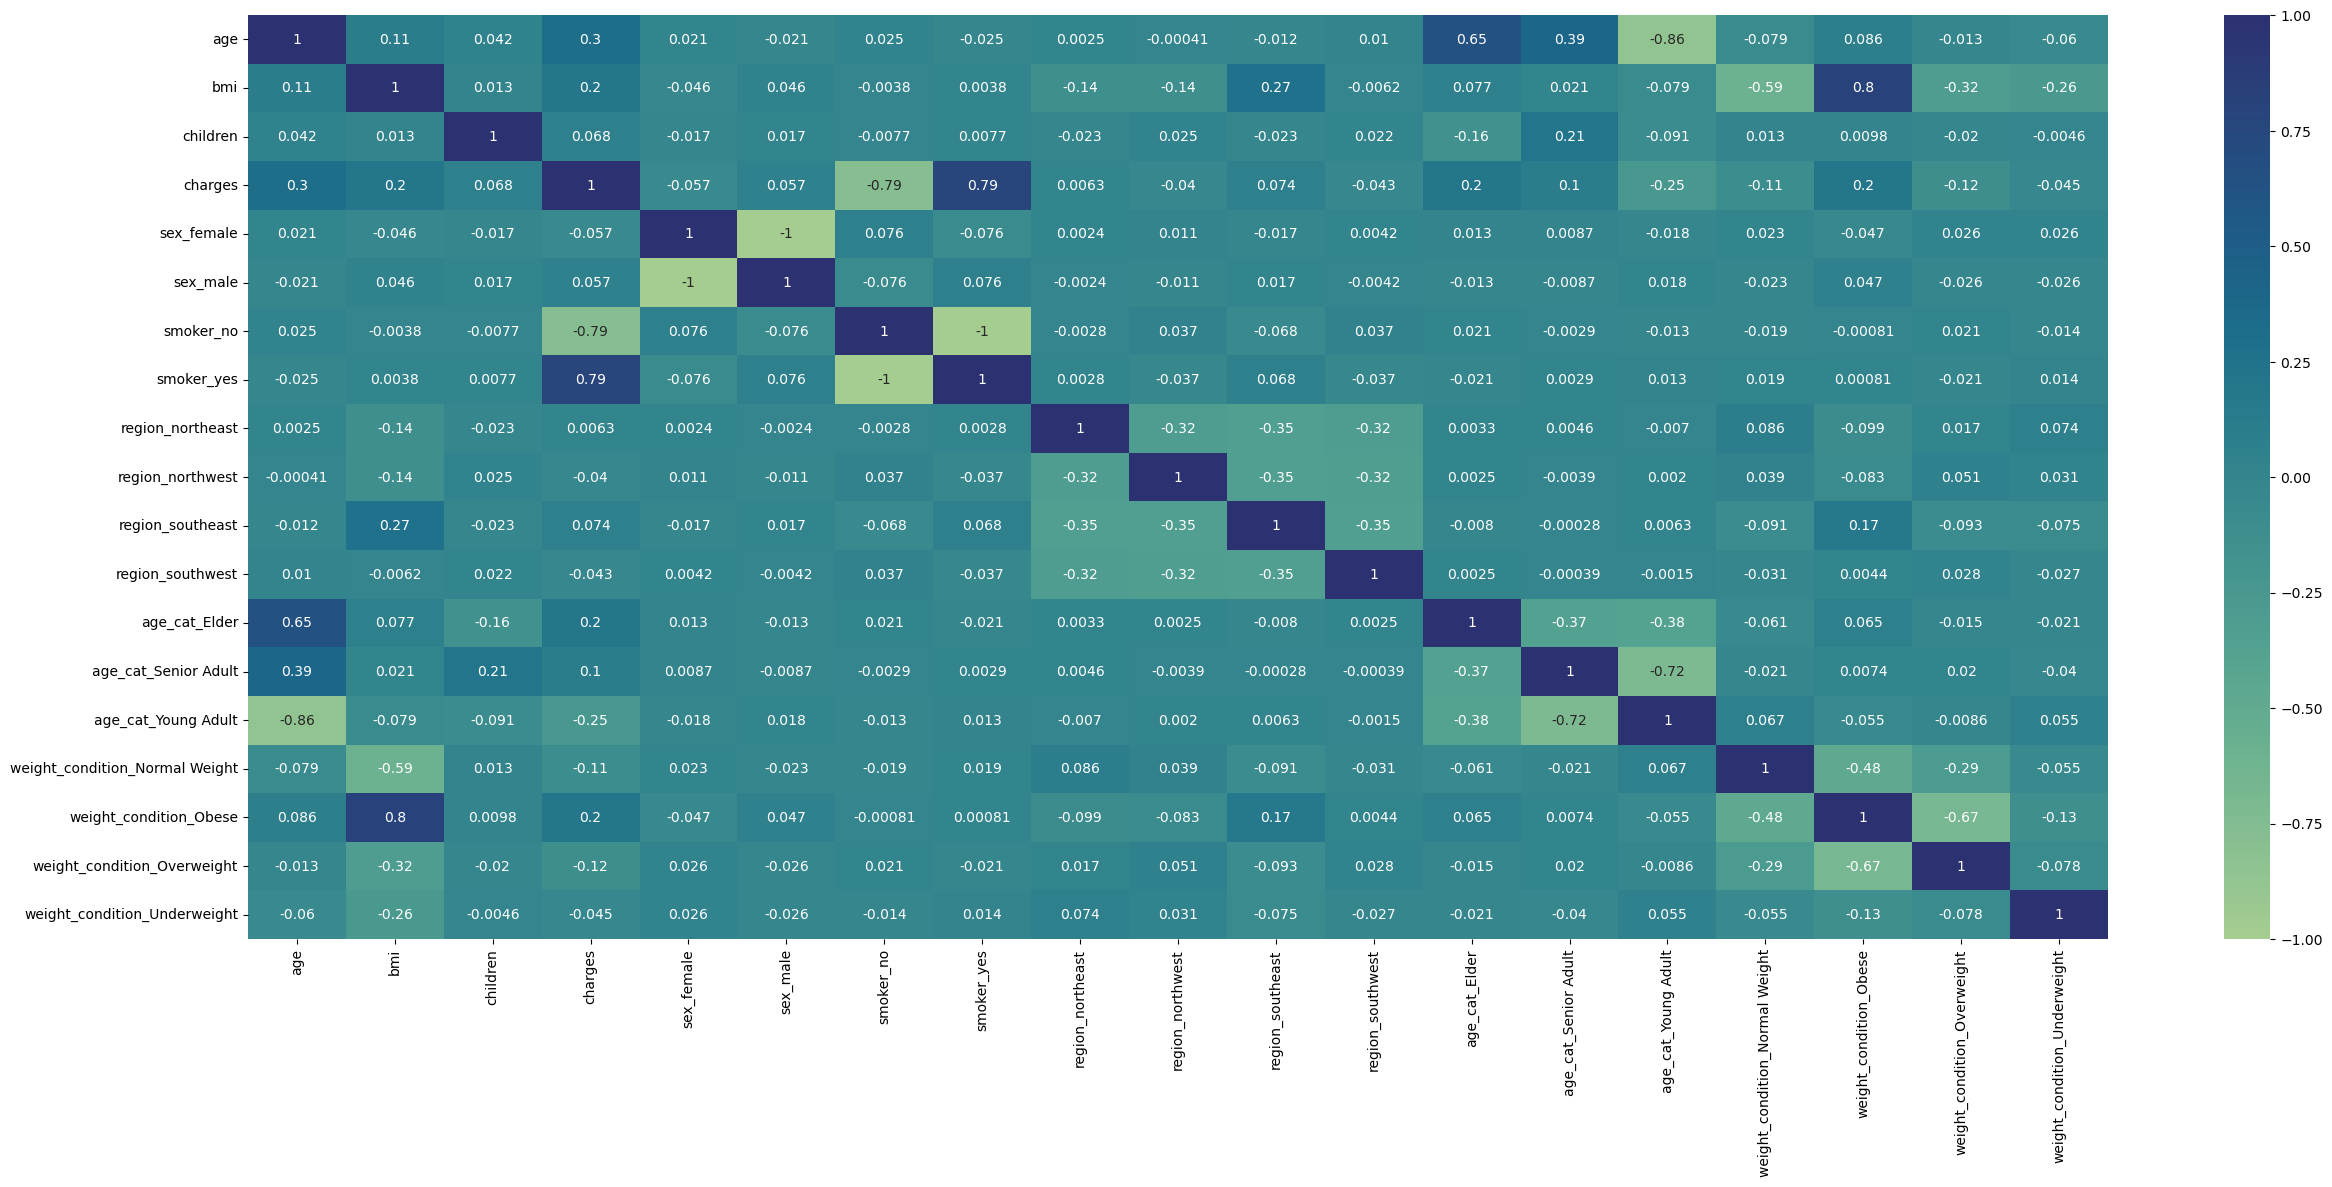

In [53]:
# Check correlations
plt.figure(figsize=(30,12))
_=sns.heatmap(med_cost.corr(), annot=True, cmap="crest")

In [54]:
# splitting data into features X, and labels y
X = med_cost.drop(['charges','age','bmi'], axis=1)
y = med_cost['charges']

In [57]:
# View X
X.head()

children  sex_female  sex_male  smoker_no  smoker_yes  region_northeast  \
0         0           1         0          0           1                 0   
1         1           0         1          1           0                 0   
2         3           0         1          1           0                 0   
3         0           0         1          1           0                 0   
4         0           0         1          1           0                 0   

   region_northwest  region_southeast  region_southwest  age_cat_Elder  \
0                 0                 0                 1              0   
1                 0                 1                 0              0   
2                 0                 1                 0              0   
3                 1                 0                 0              0   
4                 1                 0                 0              0   

   age_cat_Senior Adult  age_cat_Young Adult  weight_condition_Normal Weight  \
0                     0                    1                               0   
1                     0                    1                               0   
2                     0                    1                               0   
3                     0                    1                               1   
4                     0                    1                               0   

   weight_condition_Obese  weight_condition_Overweight  \
0                       0                            1   
1                       1                            0   
2                       1                            0   
3                       0                            0   
4                       0                            1   

   weight_condition_Underweight  
0                             0  
1                             0  
2                             0  
3                             0  
4                             0

In [58]:
# View y
y.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

In [59]:
# splitting data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, 
                                                    random_state=42)

In [60]:
# scaling values - srednia wartosc = 0 , srednie odchylenie 1
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[ 0.73433626,  1.0246016 , -1.0246016 , ..., -1.04395582,
        -0.63866637, -0.11090067],
       [-0.91119211,  1.0246016 , -1.0246016 , ..., -1.04395582,
        -0.63866637, -0.11090067],
       [-0.91119211,  1.0246016 , -1.0246016 , ..., -1.04395582,
        -0.63866637, -0.11090067],
       ...,
       [-0.91119211, -0.97598911,  0.97598911, ..., -1.04395582,
         1.56576272, -0.11090067],
       [ 0.73433626,  1.0246016 , -1.0246016 , ...,  0.95789494,
        -0.63866637, -0.11090067],
       [-0.91119211, -0.97598911,  0.97598911, ..., -1.04395582,
         1.56576272, -0.11090067]])

In [125]:
# test different algorithms to get the data predictions 
scores = []
mae_error = []
models = ['Linear Regression', 'Lasso Regression', 'AdaBoost Regression', 
          'Ridge Regression', 'RandomForest Regression', 
          'KNeighbours Regression', 'SVR']

Linear Regression R2: 0.77
Linear RegressionMAE: 4468.40


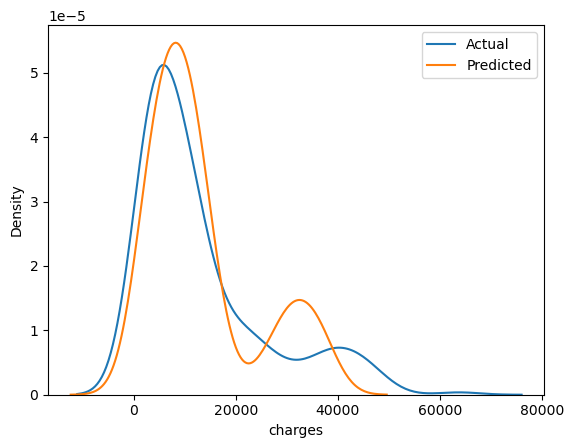

In [126]:
# Linear regression
lr = LinearRegression()
lr.fit(X_train , y_train)
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred) #porownanie testowych i wynkowych
mae = mean_absolute_error(y_test,y_pred)
mae_error.append(mae)
 
scores.append(r2)
print('Linear Regression R2: {0:.2f}'.format(r2))
print('Linear RegressionMAE: {0:.2f}'.format(mae))

sns.distplot(y_test, hist = False, label = 'Actual')
sns.distplot(y_pred, hist = False, label = 'Predicted')
plt.legend()

In [66]:
'''
# Best parameters for Lasso Regression
param  = {'alpha' : [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0],
         'fit_intercept' : ['True', 'False'],
         'max_iter' : [1000, 2000, 3000]}
glasso = GridSearchCV(estimator = Lasso(random_state=42,),
param_grid = param,scoring= 'neg_mean_squared_error' ,cv = 5,  n_jobs = -1)
glasso.fit(X_train, y_train)
glasso.best_params_, glasso.best_score_
'''

({'alpha': 8.0, 'fit_intercept': 'True', 'max_iter': 1000}, -39240269.43859058)

Lasso Regression R2: 0.77
Lasso Regression MAE: 4467.12


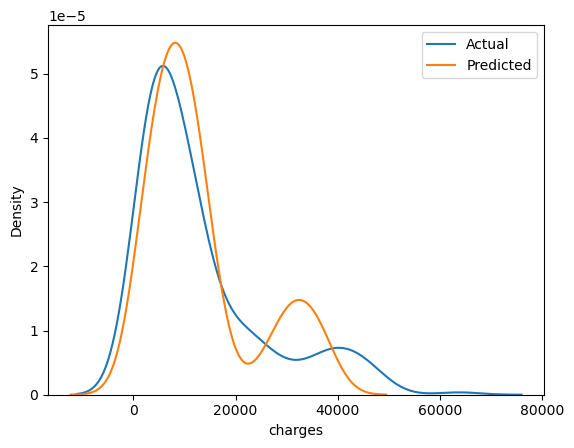

In [127]:
# Lasso
lasso = Lasso(alpha=8.0, fit_intercept=True, max_iter=1000)
lasso.fit(X_train , y_train)
y_pred = lasso.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
mae_error.append(mae)
 
scores.append(r2)
print('Lasso Regression R2: {0:.2f}'.format(r2))
print('Lasso Regression MAE: {0:.2f}'.format(mae))

sns.distplot(y_test, hist = False, label = 'Actual')
sns.distplot(y_pred, hist = False, label = 'Predicted')
plt.legend()

In [76]:
'''
# Best parameters for AdaBoost Regressor
param = {'n_estimators':[10,50,250,1000,2000],
         'learning_rate':[0.01,0.1,0.2,0.5]}
glasso = GridSearchCV(estimator = AdaBoostRegressor(random_state=42,),
param_grid = param,scoring= 'neg_mean_squared_error' ,cv = 5,  n_jobs = -1)
glasso.fit(X_train, y_train)
glasso.best_params_, glasso.best_score_
'''

({'learning_rate': 0.01, 'n_estimators': 10}, -23845023.935370862)

AdaBoost Regression R2: 0.85
AdaBoost Regression MAE: 2796.00


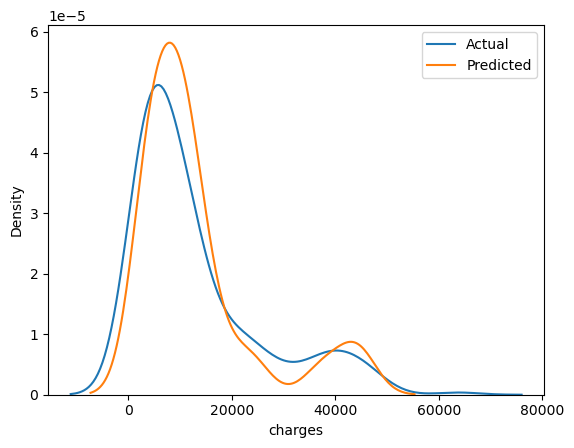

In [128]:
# Adaboost classifier
adaboost = AdaBoostRegressor(learning_rate=0.01,n_estimators=10,random_state=42)
adaboost.fit(X_train , y_train)
y_pred = adaboost.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
mae_error.append(mae)
scores.append(r2)
print('AdaBoost Regression R2: {0:.2f}'.format(r2))
print('AdaBoost Regression MAE: {0:.2f}'.format(mae))

sns.distplot(y_test, hist = False, label = 'Actual')
sns.distplot(y_pred, hist = False, label = 'Predicted')
plt.legend()

In [79]:
'''
# Best parameters for Ridge
param  = {'alpha':[0.01, 0.1, 1,10,100],
         'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
gridge = GridSearchCV(estimator = Ridge(random_state=42,),
param_grid = param,scoring= 'r2' ,cv = 5,  n_jobs = -1)
gridge.fit(X_train, y_train)
gridge.best_params_, gridge.best_score_
'''

({'alpha': 10, 'solver': 'lsqr'}, 0.7239738378381712)

Ridge Regression R2: 0.77
Ridge Regression MAE: 4471.62


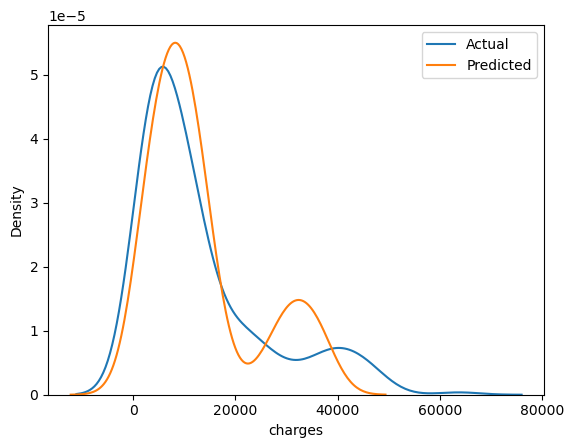

In [129]:
# Ridge
ridge = Ridge(alpha=10, solver='lsqr',random_state=42)
ridge.fit(X_train , y_train)
y_pred = ridge.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
mae_error.append(mae)
scores.append(r2)
print('Ridge Regression R2: {0:.2f}'.format(r2))
print('Ridge Regression MAE: {0:.2f}'.format(mae))

sns.distplot(y_test, hist = False, label = 'Actual')
sns.distplot(y_pred, hist = False, label = 'Predicted')
plt.legend()

In [89]:
'''
# Best parameters for Random forest
param  = {'n_estimators' : [10 ,20, 30, 40, 50, 60, 70, 80, 90, 100],
         'max_features' : ['auto', 'sqrt', 'log2'],
         'max_depth' : [3, 5, 8, 10, 15, 20, 30],
         'criterion' : ["squared_error", "absolute_error", "poisson"]}
grf = GridSearchCV(estimator = RandomForestRegressor(random_state=42,),
param_grid = param,scoring= 'r2' ,cv = 5,  n_jobs = -1)
grf.fit(X_train, y_train)
grf.best_params_, grf.best_score_
'''

({'criterion': 'squared_error',
  'max_depth': 3,
  'max_features': 'auto',
  'n_estimators': 10},
 0.8326359220282429)

Random Forest R2: 0.85
Random Forest MAE: 2776.08


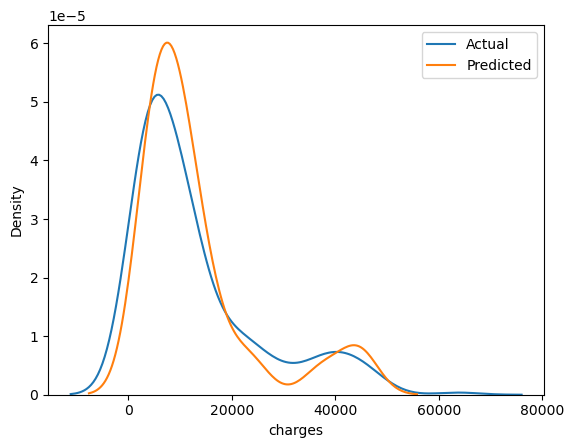

In [130]:
# Random forest
randomforest = RandomForestRegressor(criterion='squared_error',max_depth=3,max_features='auto',n_estimators=10,random_state=42)
randomforest .fit(X_train , y_train)
y_pred = randomforest .predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
mae_error.append(mae)
scores.append(r2)
print('Random Forest R2: {0:.2f}'.format(r2))
print('Random Forest MAE: {0:.2f}'.format(mae))

sns.distplot(y_test, hist = False, label = 'Actual')
sns.distplot(y_pred, hist = False, label = 'Predicted')
plt.legend()

In [97]:
'''
# Best parameters for KNeighbours
param = {'n_neighbors':[3, 5, 10, 15, 20],
         'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
          'weights' : ['uniform', 'distance'],
         'leaf_size' : [10, 20, 30, 40, 50]}
gkn = GridSearchCV(estimator = KNeighborsRegressor(),
param_grid = param,scoring= 'neg_mean_squared_error' ,cv = 5,  n_jobs = -1)
gkn.fit(X_train, y_train)
gkn.best_params_, gkn.best_score_
'''

({'algorithm': 'kd_tree',
  'leaf_size': 20,
  'n_neighbors': 10,
  'weights': 'uniform'},
 -28660407.28295352)

K-Neighbours Regression R2: 0.82
K-Neighbours MAE: 3341.95


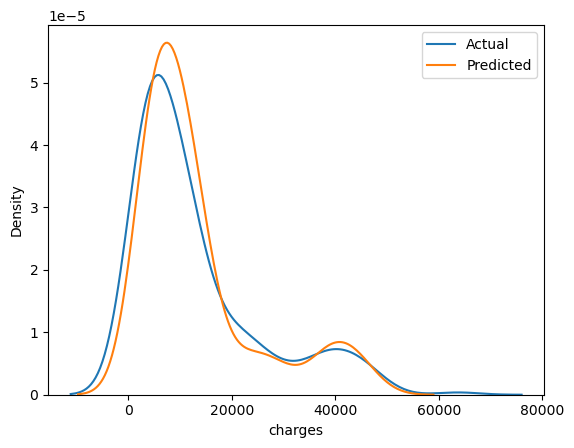

In [131]:
# K-Neighbours
kneighbours = KNeighborsRegressor(algorithm='kd_tree',leaf_size=20,n_neighbors=10,weights='uniform')
kneighbours.fit(X_train , y_train)
y_pred = kneighbours.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
mae_error.append(mae)
scores.append(r2)
print('K-Neighbours Regression R2: {0:.2f}'.format(r2))
print('K-Neighbours MAE: {0:.2f}'.format(mae))

sns.distplot(y_test, hist = False, label = 'Actual')
sns.distplot(y_pred, hist = False, label = 'Predicted')
plt.legend()

In [100]:
'''
# Best parameters for SVR
param  = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
         'gamma' : ['scale', 'auto'],
         'C': [1.0, 2.0, 3.0, 4.0],
         'epsilon' : [0.1, 0.2, 0.3, 0.4, 0.5]}
gsvr = GridSearchCV(estimator = SVR(),
param_grid = param,scoring= 'r2' ,cv = 5,  n_jobs = -1)
gsvr.fit(X_train, y_train)
gsvr.best_params_, gsvr.best_score_
'''

({'C': 4.0, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'linear'},
 0.34934094987850667)

SVR R2: 0.45
SVR MAE: 5291.74


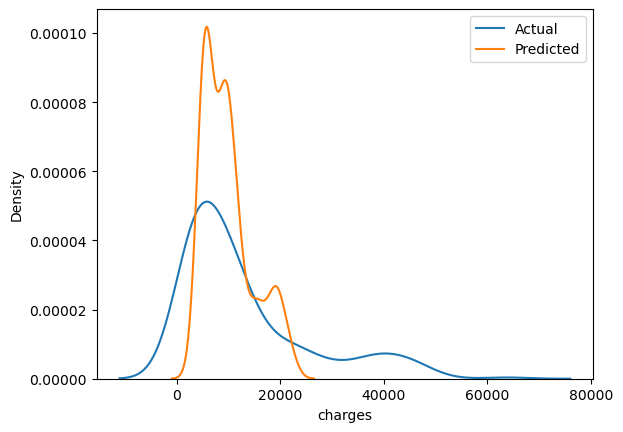

In [132]:
# SVR
svr = SVR(C=4.0, epsilon=0.5, gamma='scale',kernel='linear')
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
mae_error.append(mae)
scores.append(r2)
print("SVR R2: {0:.2f}".format(r2))
print('SVR MAE: {0:.2f}'.format(mae))

sns.distplot(y_test, hist = False, label = 'Actual')
sns.distplot(y_pred, hist = False, label = 'Predicted')
plt.legend()

In [133]:
# Ranking
ranking = pd.DataFrame({'Algorithms' : models, 'R2-Score' : scores, 'Mean Absolute Error' : mae_error})
ranking = ranking.sort_values(by='R2-Score', ascending=False)
ranking

Algorithms  R2-Score  Mean Absolute Error
2      AdaBoost Regression  0.852672          2796.002363
4  RandomForest Regression  0.852477          2776.077642
5   KNeighbours Regression  0.819795          3341.948128
0        Linear Regression  0.767019          4468.395708
1         Lasso Regression  0.766933          4467.118953
3         Ridge Regression  0.766669          4471.616012
6                      SVR  0.447384          5291.739587

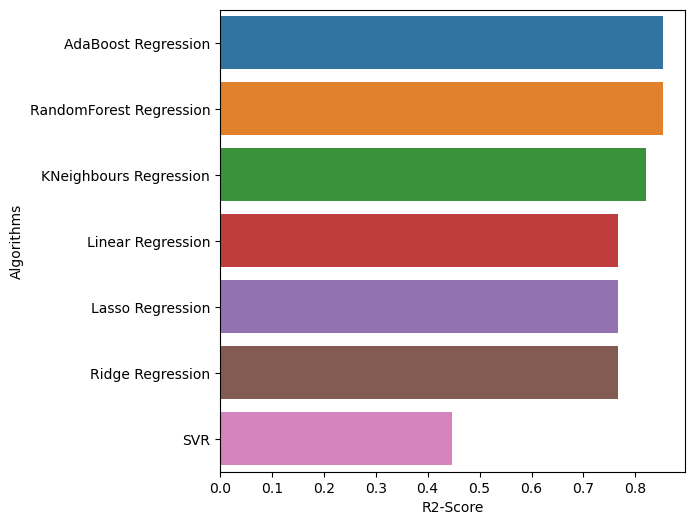

In [134]:
plt.figure(figsize=(6,6))
sns.barplot(x='R2-Score', y='Algorithms', data=ranking[['Algorithms', 'R2-Score']]);

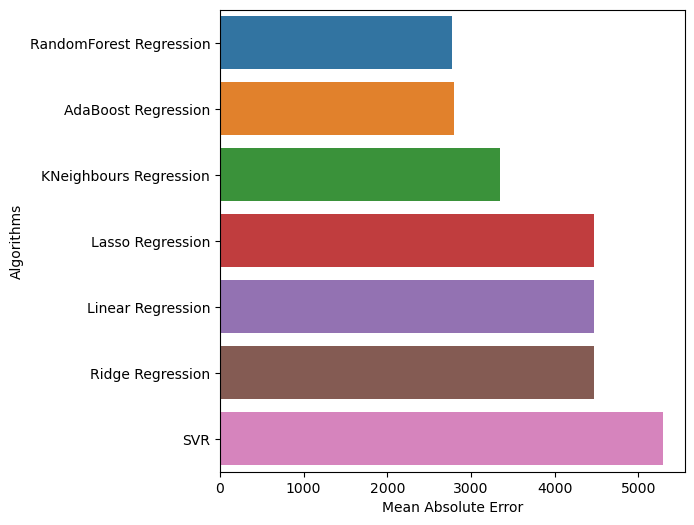

In [135]:
ranking = ranking.sort_values(by='Mean Absolute Error', ascending=True)
plt.figure(figsize=(6,6))
sns.barplot(x='Mean Absolute Error', y='Algorithms', data=ranking[['Algorithms', 'Mean Absolute Error']]);